In [67]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/2Spin`


In [68]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, LaTeXStrings
import PyPlot as plt
using PyCall, Conda

In [9]:
function gen_J(N, K, J_params; rng=Xoshiro(1234))
    J = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
    @inbounds @fastmath for i in 1:N
        @inbounds @fastmath for j in i+1:N
            if J[i, j] ≠ 0
                Jval = J_params[1]/sqrt(K) * (rand(rng) < 0.5 ? 1 : -1)
                J[i, j] = Jval
                J[j, i] = Jval
            end
        end
    end
    dropzeros!(J)
    return J
end

gen_J (generic function with 1 method)

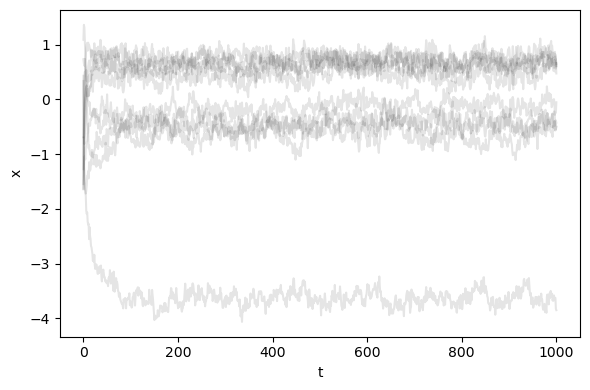

In [10]:
N, K = 100, 3

rng = Xoshiro(1234)

J, D = 1.0, 0.01
Jmat = gen_J(N, K, [J]; rng=rng)

model = TwoSpinModel(K, Jmat, D)


x0_min, x0_max = -3.0, 3.0
x0 = rand(rng, N) .* (x0_max - x0_min) .+ x0_min
x0 .*= sqrt(N / sum(x0 .^ 2))
tmax = 1000.0 
tsave=collect(range(0.0, tmax; length=1000))

tvec, trajs = sample_2Spin(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:10
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

In [59]:
N, K = 1000, 10

rng = Xoshiro(1234) 
J, D = 1.0, 0.3

x0_min, x0_max = -3.0, 3.0
dt = 1e-3
tmax = 6e2
tsave = collect(range(0.0, tmax; step=1e-1))

nsim = 10;

In [60]:
# Define ensemble model
model_ensemble = TwoSpinModelRRG(N, K, J, D)

# Sample ensemble
tvals_alls, traj_alls, lambda_traj_alls = sample_ensemble_2Spin(model_ensemble, x0_min, x0_max, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt);

Progress: 100%|███████████████████████████| Time: 0:01:17 ( 7.72  s/it)


In [13]:

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true, sharey=true)
# Only averages
ax = axs[1]
mean_traj, std_traj, autocorr_traj = compute_stats(traj_alls)
ax.plot(tvals_alls[1], mean_traj, color="red")
ax.fill_between(tvals_alls[1], mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
for isim in 1:nsim
    mean, std, autocorr = compute_stats(traj_alls[isim])
    ax.plot(tvals_alls[isim], mean, color="k", alpha=0.1)
    ax.fill_between(tvals_alls[isim], mean .- std, mean .+ std, color="gray", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")
# Method 2
ax = axs[2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end
ax.set_xlabel("t")
plt.display(fig)

# Plotting the correlation function at different waiting times and lambdas
tw_idxs = [5, 10, 30, 70, 100, 200]
tws = tsave[tw_idxs]
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true)
# Plot the correlation function at different waiting times
mean_traj, std_traj, autocorr_traj = compute_stats(traj_alls)
for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws, tw_idxs))
    ax.plot(tsave[tw_idx:end] .- tw, autocorr_traj[tw_idx:end, tw_idx] ./ autocorr_traj[tw_idx, tw_idx], color="C$i", label="tw = $(round(tw, digits=0))")
end
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("C(tw + t, tw)")
ax.legend()
plt.display(fig)

# Plot lambdas


MethodError: MethodError: no method matching _autocorr(::SubArray{Float64, 2, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}; dims::Int64)

Closest candidates are:
  _autocorr(!Matched::Matrix{Tx}; dims) where Tx<:Real
   @ GaussianExpansionCavityMethod ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/utils.jl:23


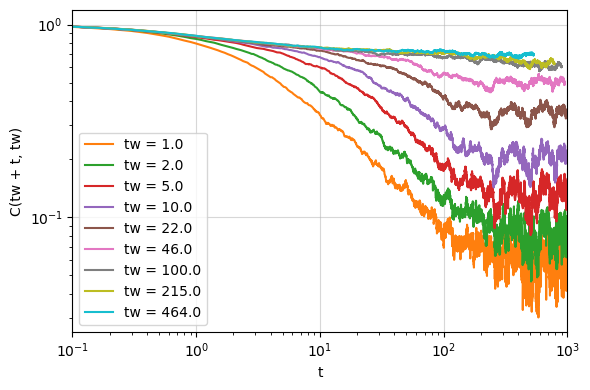

In [58]:
C, tidxs = compute_autocorr(traj_alls)
tvec = tsave[tidxs]

tws = collect(10 .^ range(log10(1.0), stop=log10(1000.0), length=10))[1:end-1]
tw_idxs = [argmin(abs.(tvec .- tw)) for tw in tws]

tws_real = tvec[tw_idxs]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws_real, tw_idxs))
    ax.plot(tvec[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color="C$i", label="tw = $(round(tw, digits=0))")
end
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1,1e3)
ax.set_xlabel("t")
ax.set_ylabel("C(tw + t, tw)")
ax.grid(alpha=.5)
ax.legend()
plt.display(fig)

In [62]:
C, tidxs = compute_autocorr(traj_alls)
tvec = tsave[tidxs]

# Plot correlations
tws = collect(10 .^ range(log10(1.0), stop=log10(1000.0), length=10))[1:end-1]
tw_idxs = [argmin(abs.(tvec .- tw)) for tw in tws]
tws_real = tvec[tw_idxs]

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Initialize color map
my_cmap = plt.matplotlib[:cm][:hot]
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.matplotlib[:colors][:LogNorm](vmin=1, vmax=1000))

step = 220/10
for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws_real, tw_idxs))
    ax.plot(tvec[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(floor(Int, (i-1)*step)))
end
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1,1e2)
ax.set_ylim(C[end,tw_idxs[1]], 1.001)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
clb = plt.colorbar(sm, ax=ax, title=L"t_w")
clb.ax.set_title(L"t_w")

LoadError: LoadError: UndefVarError: `@L_str` not defined
in expression starting at /Users/mattiatarabolo/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/2Spin/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:24

In [ ]:
function compute_autocorr2(sim::Vector{Matrix{Float64}}; time_indices=nothing)
    nsim = length(sim)
    N, T = size(sim[1])
    # Filter time indices
    if time_indices === nothing
        t_idx = 1:T
    else
        t_idx = filter(t -> 1 ≤ t ≤ T, time_indices)
    end
    T_eff = length(t_idx)

    # Initiliaze correlation matrix
    C = zeros(T_eff, T_eff)

    # Compute correlations for each simulation and add to the matrix
    for isim in 1:nsim
        # Compute the autocorrelation at different times
        C .+= GaussianExpansionCavityMethod._autocorr(sim[isim][:,t_idx]; dims=1) # Covariance matrix
    end

    # Average over the simulations
    C ./= nsim

    return C, t_idx
end

C, tidxs = compute_autocorr2(traj_alls)
tvec = tsave[tidxs]

# Plot correlations
tws = collect(10 .^ range(log10(1.0), stop=log10(1000.0), length=10))[1:end-1]
tw_idxs = [argmin(abs.(tvec .- tw)) for tw in tws]
tws_real = tvec[tw_idxs]

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Initialize color map
my_cmap = plt.matplotlib[:cm][:hot]
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.matplotlib[:colors][:LogNorm](vmin=1, vmax=1000))

step = 220/10
for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws_real, tw_idxs))
    ax.plot(tvec[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(floor(Int, (i-1)*step)))
end
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1,1e2)
ax.set_ylim(C[end,tw_idxs[1]], 1.001)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

plt.display(fig)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/mattiatarabolo/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("Colorbar.__init__() got an unexpected keyword argument 'title'")
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/matplotlib/pyplot.py", line 2526, in colorbar
    ret = gcf().colorbar(mappable, cax=cax, ax=ax, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mattiatarabolo/.julia/conda/3/aarch64/lib/python3.12/site-packages/matplotlib/figure.py", line 1308, in colorbar
    cb = cbar.Colorbar(cax, mappable, **{
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


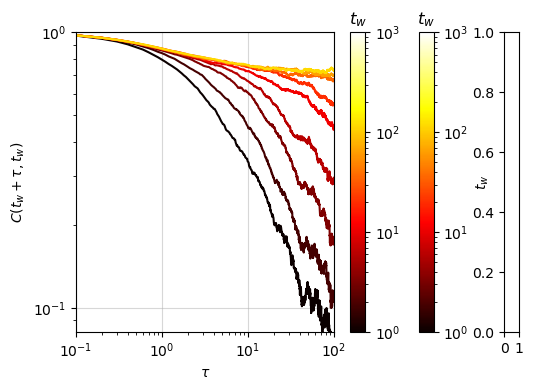

In [83]:
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1,1e2)
ax.set_ylim(C[end,tw_idxs[1]], 1.001)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

plt.display(fig)